# Exercise Sheet No. 10

---

> Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 29.06.2021, 8 am
> 
> Tutor: patrick.reiser@kit.edu  
> **Please ask questions in the forum and only contact the Tutor when there are issues with the grading**

---
**Topic**: This exercise sheet will introduce you to machine learning on graphs.

# Graph Theory
"In mathematics, graph theory is the study of graphs, which are mathematical structures used to model pairwise relations between objects. A graph in this context is made up of vertices (also called nodes or points) which are connected by edges (also called links or lines). A distinction is made between undirected graphs, where edges link two vertices symmetrically, and directed graphs, where edges link two vertices asymmetrically. Graphs are one of the principal objects of study in discrete mathematics." ([wikipedia](https://en.wikipedia.org/wiki/Graph_theory))

In one restricted but very common sense of the term, a graph is an ordered pair $G = ( V , E )$ comprising:

* $V$, a set of vertices (also called nodes or points);
* $E\subseteq \{\{x,y\}\mid x,y\in V\;{\textrm {and}}\;x\neq y\}$, a set of edges (also called links or lines), which are unordered pairs of vertices (that is, an edge is associated with two distinct vertices).

To avoid ambiguity, this type of object may be called precisely an undirected simple graph. 

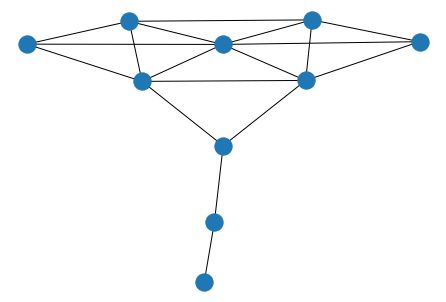

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
# Example of a graph
G = nx.krackhardt_kite_graph()
nx.draw(G)

# Graph convolutional neural networks (GCN)

Graph convolutional neural networks are a natural extenstion of CNNs for graph-structured data. A simple but efficient Graph neural network was introduced ["Semi-Supervised Classification with Graph Convolutional Networks"](https://arxiv.org/abs/1609.02907) by Kipf et al. (2016). Below is a description of the model and its applications taken from https://tkipf.github.io/graph-convolutional-networks/. We will implement this model and test it on some graph data.

### GCNs Part I: Definitions

Currently, most graph neural network models have a somewhat universal architecture in common. I will refer to these models as Graph Convolutional Networks (GCNs); convolutional, because filter parameters are typically shared over all locations in the graph (or a subset thereof as in [Duvenaud et al., NIPS 2015](https://proceedings.neurips.cc/paper/2015/hash/f9be311e65d81a9ad8150a60844bb94c-Abstract.html)).

For these models, the goal is then to learn a function of signals/features on a graph $G=(V,E)$ which takes as input:

* A feature description $x_i$ for every node $i$; summarized in a $N\times D$ feature matrix $X$ ($N$: number of nodes, $D$: number of input features)
* A representative description of the graph structure in matrix form; typically in the form of an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) $A$ (or some function thereof)

and produces a node-level output $Z$ (an $N\times F$ feature matrix, where $F$ is the number of output features per node). Graph-level outputs can be modeled by introducing some form of pooling operation (see, e.g. [Duvenaud et al., NIPS 2015](https://proceedings.neurips.cc/paper/2015/hash/f9be311e65d81a9ad8150a60844bb94c-Abstract.html)).

Every neural network layer can then be written as a non-linear function

$$H^{(l+1)}=f(H^{(l)},A),$$

with $H^{(0)}=X$ and $H^{(L)}=Z$ (or $z$ for graph-level outputs), $L$ being the number of layers. The specific models then differ only in how $f(⋅,⋅)$ is chosen and parameterized.

### GCNs Part II: A simple example

As an example, let's consider the following very simple form of a layer-wise propagation rule:

$$f(H^{(l)},A)= \sigma (AH^{(l)}W^{(l)}),$$

where $W^{(l)}$ is a weight matrix for the $l$-th neural network layer and $\sigma(⋅)$ is a non-linear activation function like the ReLU. Despite its simplicity this model is already quite powerful (we'll come to that in a moment).

But first, let us address two limitations of this simple model: multiplication with $A$ means that, for every node, we sum up all the feature vectors of all neighboring nodes but not the node itself (unless there are self-loops in the graph). We can "fix" this by enforcing self-loops in the graph: we simply add the identity matrix to $A$.

The second major limitation is that $A$ is typically not normalized and therefore the multiplication with $A$ will completely change the scale of the feature vectors (we can understand that by looking at the eigenvalues of $A$). Normalizing $A$ such that all rows sum to one, i.e. $D^{−1}A$, where $D$ is the diagonal node degree matrix, gets rid of this problem. Multiplying with $D^{−1}A$ now corresponds to taking the average of neighboring node features. In practice, dynamics get more interesting when we use a symmetric normalization, i.e. $D^{−\frac{1}{2}} A D^{−\frac{1}{2}}$ (as this no longer amounts to mere averaging of neighboring nodes). Combining these two tricks, we essentially arrive at the propagation rule introduced in [Kipf & Welling](https://arxiv.org/abs/1609.02907) (ICLR 2017): 

$$f(H^{(l)},A)=\sigma \, ( \hat{D}^{−\frac{1}{2}} \hat{A} \hat{D}^{−\frac{1}{2}} H^{(l)}W^{(l)}),$$

with $\hat{A}=A+I$, where $I$ is the identity matrix and $\hat{D}$ is the diagonal node degree matrix of $\hat{A}$.

Next, we will take a closer look at how this type of model operates on a very simple example graph: Zachary's karate club network (make sure to check out the [Wikipedia article](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)!). A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split. 

Example of labels[5:15] : ['Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Officer', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Officer']


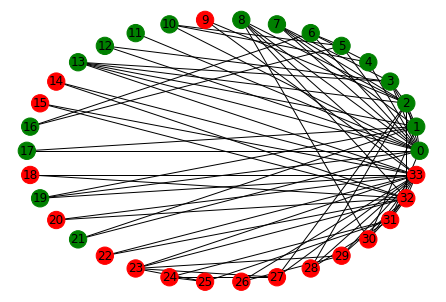

In [2]:
G = nx.karate_club_graph()
labels = [G.nodes()[i]['club'] for i in range(nx.number_of_nodes(G))]
print("Example of labels[5:15] :",labels[5:15])
labels_onehot = [0 if x=='Mr. Hi' else 1 for x in labels]
labels_color = ['green' if x=='Mr. Hi' else "red" for x in labels]
nx.draw_circular(G, with_labels=True, node_color = labels_color)
plt.show()

In [3]:
import scipy
import numpy as np
import scipy.sparse as sp
import numpy as np
# Adjacency matrix as sparse matrix
# Note: Larger graphs can not be stored in memory anymore
A = nx.adjacency_matrix(G)
print(A.toarray())

[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


### 10.1 Normalized adjacency matrix
Compute the prescaled adjacency matrix $A_s = \hat{D}^{−\frac{1}{2}} \hat{A} \hat{D}^{−\frac{1}{2}}$, with $\hat{A}=A+I$, where $I$ is the identity matrix and $\hat{D}$ is the diagonal node degree matrix of $\hat{A}$.
You have to implement ``compute_scaled_DAD`` using scipy's sparse matrix functions, such as `.sum`, `sp.diag`, `sp.eye`, `.shape`, `.transpose` and `.dot`. It is okay to compute the power of the row- and column sum with `numpy`. You may have to check for `np.inf` here when taking $\hat{D}^{−\frac{1}{2}}$.

In [62]:
def compute_scaled_DAD(adj):
    """Compute scaled adjacency matrix D^-0.5*(A + I)*D^-0.5
    with the degree matrix D of (A+I).
    
    Args:
        adj (scipy.sparse): Sparse matrix representation of A with shape (N, N)
    
    Returns:
        sp.coo.coo_matrix: Sparse matrix representation of D^-0.5*(A + I)*D^-0.5
    """
    # create diagonal
    A = adj + np.identity(adj.shape[0])
    n = np.sum(A, axis=1)
    D = np.eye(n.shape[0])
    np.fill_diagonal(D, n)
    
    D_s = np.power(D, -0.5)
    
    # replace all inf with 0
    D_s[np.isinf(D_s)] = 0
    
    a_scaled = (D_s @ A @ D_s)
    
    return sp.coo.coo_matrix(a_scaled)

In [63]:
# test on the Karate Club network
Ascaled = compute_scaled_DAD(A)

<ipython-input-62-adfc796d9cd3>:17: RuntimeWarning: divide by zero encountered in power
  D_s = np.power(D, -0.5)


In [64]:
assert isinstance(Ascaled, sp.coo.coo_matrix)
assert np.amax(np.abs(Ascaled.tocoo().toarray()[:5,:5]-np.array(
    [[0.05882353, 0.0766965 , 0.07312724, 0.09166985, 0.12126781],
       [0.0766965 , 0.1       , 0.09534626, 0.11952286, 0.        ],
       [0.07312724, 0.09534626, 0.09090909, 0.11396058, 0.        ],
       [0.09166985, 0.11952286, 0.11396058, 0.14285714, 0.        ],
       [0.12126781, 0.        , 0.        , 0.        , 0.25      ]]))) < 1e-4

Now we implement the model in TensorFlow, where the node features and the pre-scaled adjacency matrix are model inputs. The actual convolution realized by a (sparse) matrix multiplication is given in the layer below: `GCNConvolution`. This means the scaling does not to be performed within the model but can be done beforehand via `compute_scaled_DAD`.

In [65]:
import tensorflow as tf
class GCNConvolution(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(GCNConvolution, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        adj, x = inputs 
        return tf.sparse.sparse_dense_matmul(adj, x)

We set up the model in the functional API for TensorFlow Keras. You can read about this here: https://www.tensorflow.org/guide/keras/functional. A skeleton of the intended model is shown below. You have to add 3 layers of convolution. For the weights $W^{(l)}$ you can simply use `tf.keras.layers.Dense` with `linear` activation and without any `use_bias=False` and for the non-linearity after the matrix multiplication you can use `tf.keras.layers.Activation`. For activation you can use ``"relu"`` and the dimension of the kernel is given already below as `hidden_dim`. We wrote some pseudo-code in the section, where you have to implement the model-part.

In [72]:
# Model properties
hidden_dim = 34
target_dim = 2
depth = 3
# Model definition
input_adj = tf.keras.layers.Input(shape=(34,), name='adj_input', dtype="float32", sparse=True) # Scaled Adjacency matrix
input_feat = tf.keras.layers.Input(shape=(34,), name='node_input', dtype="float32") # Node features
x = input_feat
for i in range(depth):
    # Pseudo-Code of the model "x = D^-0.5*(A + I)*D^-0.5 * W *x"
    #
    # x = W*x (via tf.keras.layers.Dense(hidden_dim))
    # x = A_scaled * x (via GCNConvolution())
    # x = sigma(x) (via tf.keras.layers.Activation('relu'))
    #
    # YOUR CODE HERE
    # x1 = tf.keras.layers.Dense(hidden_dim, activation="linear", use_bias=False)(x)
    # x2 = GCNConvolution()((input_adj, x))
    # x3 = tf.keras.layers.Activation('relu')(x2)
    # x = x3
    x = tf.keras.layers.Dense(hidden_dim, activation="linear", use_bias=False)(x)
    x = GCNConvolution()((input_adj,x))
    x = tf.keras.layers.Activation('relu')(x)
    
out_classes = tf.keras.layers.Dense(target_dim, activation='softmax')(x)
model = tf.keras.models.Model(inputs=[input_adj, input_feat], outputs=out_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
adj_input (InputLayer)          [(None, 34)]         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 34)           1156        node_input[0][0]                 
__________________________________________________________________________________________________
gcn_convolution_4 (GCNConvoluti (None, 34)           0           adj_input[0][0]                  
                                                                 dense_5[0][0]              

We will train the model above on a semi-supervised learning procedure, meaning that we will train the model on the Karate club network with a couple of nodes cloaked or covered and then test if the network can predict the right assignment of the unkown students. Since the network does not have features `X`, we will simply assume `X=I`. Check the code below.

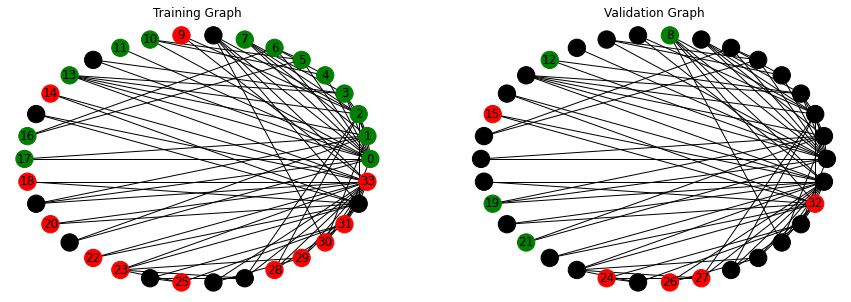

In [73]:
from sklearn.model_selection import train_test_split
# Features and labels
X = np.eye(34)
Y = np.array([[1,0] if x=='Mr. Hi' else [0,1] for x in labels])
As = Ascaled.tocsr().sorted_indices().tocoo()
# Train validatoin mask to cover nodes in the training
index_karate = np.arange(34)
ind_train, ind_val = train_test_split(index_karate, test_size=0.25, random_state=42)
val_mask = np.zeros_like(index_karate)
train_mask = np.zeros_like(index_karate)
val_mask[ind_val] = 1
train_mask[ind_train] = 1
#Draw the graphs
plt.figure(figsize=(15,5))
plt.subplot(121)
nx.draw_circular(G, with_labels=True, node_color = [x if train_mask[i]==1 else 'black' for i,x in enumerate(labels_color)])
plt.title("Training Graph")
plt.subplot(122)
nx.draw_circular(G, with_labels=True, node_color = [x if val_mask[i]==1 else 'black' for i,x in enumerate(labels_color)])
plt.title("Validation Graph")
plt.show()

We can use TensorFlow Keras API to train the model with some modifications. This is a somewhat hacky solution and not really as the Keras training API is intended. We directly insert the sparse matrix and Keras will think of the nodes as samples. We therefore have to fix the `batch_size=34`. Also we must prevent shuffling of the nodes (that will destroy our graph) and set `shuffle=False`. The covering of validation node labels can be realized with a `sample_weight=train_mask` that sets the validation nodes to zero in the loss (since nodes correspond to samples in this case).

In [74]:
# Compile model with optimizer and loss
learning_rate_start = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_start)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['categorical_accuracy'])
hist = model.fit([As, X], Y,
                 epochs=100,
                 batch_size=34,
                 verbose=1,
                 shuffle=False,  # Since we do not really have batches, nodes must not be shuffled
                 sample_weight=train_mask  # Important to hide values from 
                 )

Epoch 1/100
1/1 [==============================] - 0s 445ms/step - loss: 0.5121 - categorical_accuracy: 0.2800
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.5106 - categorical_accuracy: 0.3200
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5093 - categorical_accuracy: 0.3600
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5080 - categorical_accuracy: 0.6000
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5068 - categorical_accuracy: 0.6000
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5056 - categorical_accuracy: 0.6000
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5043 - categorical_accuracy: 0.6400
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5031 - categorical_accuracy: 0.6400
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5018 - categorical_accuracy: 0.6800
Epoch 10/100
1/1 

In [75]:
val_loss = model.evaluate([As, X], Y, batch_size=34, sample_weight=val_mask)

1/1 [==============================] - 0s 189ms/step - loss: 0.0544 - categorical_accuracy: 0.8889


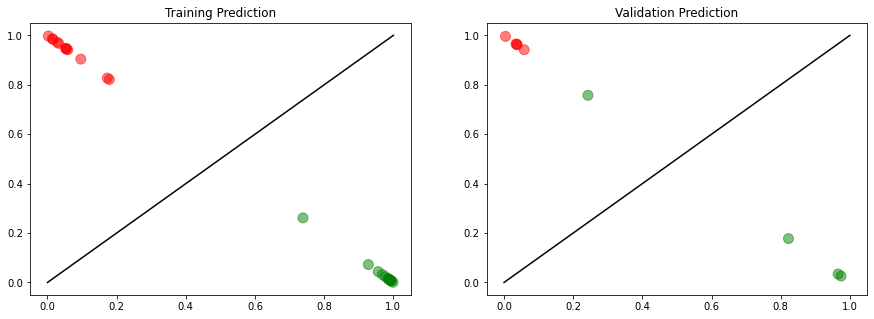

In [76]:
pred = model.predict([As, X], batch_size=34)
pred_val = pred[np.array(val_mask,dtype="bool")]
pred_train = pred[np.array(train_mask,dtype="bool")]
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(pred_train[:,0],pred_train[:,1], s=100, alpha=0.5, c=[x for i,x in enumerate(labels_color) if train_mask[i]==1])
plt.plot((0,1),c='black')
plt.title("Training Prediction")
plt.subplot(122)
plt.scatter(pred_val[:,0],pred_val[:,1], s=100, alpha=0.5, c=[x for i,x in enumerate(labels_color) if val_mask[i]==1])
plt.title("Validation Prediction")
plt.plot((0,1),c='black')
plt.show()

In [77]:
assert val_loss[-1] > 0.8
assert hist.history['categorical_accuracy'][-1] > 0.95

Why is it not suprising that the training accuracy approaches 1.0 ? But why is it interesting that the valdiation accuracy is high?

In [78]:
answer_training_acc = """
We are strongly overfitting, given that we only have a few nodes. 
After just a few iterations of passing information around, we already approch a perfect score --> Overfitting.
"""
answer_validation_acc = """
Normally, when a model approaches 100% training accuracy you start to suspect Overfitting.
When a model overfits, it normally performs worse on the validation set.
"""

In [79]:
assert isinstance(answer_training_acc, str)
assert isinstance(answer_validation_acc, str)

# 10.2 Molecules
Molecules can also be represented as graphs. In this case we have many small(er) graphs and are intereseted in graph-embedding or graph-classification rather than node-embedding or -classification. For this part we use the MUTAG dataset  that classifies a set of small molecules as mutagenes.

In [80]:
import requests
import zipfile
import os
data_url = "https://ls11-www.cs.tu-dortmund.de/people/morris/graphkerneldatasets/MUTAG.zip"
if not os.path.exists("MUTAG.zip"):
    print("Downloading dataset ...")
    r = requests.get(data_url) 
    _ = open("MUTAG.zip",'wb').write(r.content)
    archive = zipfile.ZipFile("MUTAG.zip", "r")
    archive.extractall()

In [81]:
def read_mutag_text(filename):
    mutag_txt = []
    open_file = open(filename, "r")
    for lines in open_file.readlines():
        idxs = lines.strip().split(',')
        idxs = [int(x) for x in idxs]
        mutag_txt.append(idxs)
    open_file.close()
    return np.array(mutag_txt, dtype="int")
# Read all mutag files
mutag_A = read_mutag_text("MUTAG/MUTAG_A.txt")
mutag_E = read_mutag_text("MUTAG/MUTAG_edge_labels.txt")
mutag_G = read_mutag_text("MUTAG/MUTAG_graph_indicator.txt")
mutag_N = read_mutag_text("MUTAG/MUTAG_node_labels.txt")
mutag_L = read_mutag_text("MUTAG/MUTAG_graph_labels.txt")
print("Shape of", "A:",mutag_A.shape, ", Edges:", mutag_E.shape,", Graph-ID:", mutag_G.shape,", Nodes:", mutag_N.shape,", Graph-label:", mutag_L.shape)
# Want to start index from zero and not from 1
mutag_A = mutag_A-1
mutag_G = mutag_G-1

Shape of A: (7442, 2) , Edges: (7442, 1) , Graph-ID: (3371, 1) , Nodes: (3371, 1) , Graph-label: (188, 1)


In [82]:
# Separate the molecular graphs:
atom_code = ["C", "N", "O", "F", "I", "Cl", "Br"]
atom_color_map = {"C": "grey", "N": "green", "O": "blue", "F" : "purple", "I" : "yellow", "Cl":"pink", "Br": "orange"}
all_graphs = nx.Graph()
for i in range(len(mutag_N)):
    one_hot_atom_embedding = [0] * len(atom_code) # There are 7 elements in the dataset
    one_hot_atom_embedding[mutag_N[i][0]] = 1
    str_atom_name=atom_code[mutag_N[i][0]]
    all_graphs.add_node(i, 
                        features=one_hot_atom_embedding, 
                        atom_name=str_atom_name)
for i in range(len(mutag_A)):
    one_hot_bond_embedding = [0] * 4 # There are 3 bond types in the dataset
    one_hot_bond_embedding[mutag_E[i][0]] = 1
    all_graphs.add_edge(mutag_A[i][0], mutag_A[i][1], 
                        features=one_hot_bond_embedding)
graphs = []
nodes = np.arange(0,len(mutag_N),1)
for g in range(0,np.amax(mutag_G)):
    graphs.append(all_graphs.subgraph(nodes[mutag_G[:,0]==g]).to_directed())

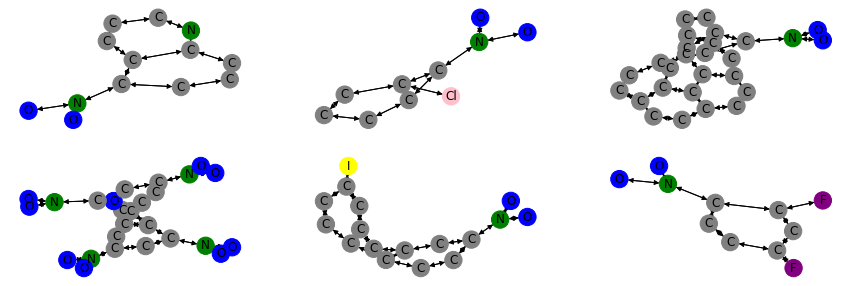

In [83]:
def plot_sub_graph(gri_plot):
    nx.draw(graphs[gri_plot], labels={n: (graphs[gri_plot].nodes()[n]['atom_name']) for n in graphs[gri_plot].nodes()},
        node_color = [atom_color_map[graphs[gri_plot].nodes()[n]['atom_name']] for n in graphs[gri_plot].nodes()])
plt.figure(figsize=(15,5))
plt.subplot(231)
plot_sub_graph(2)
plt.subplot(232)
plot_sub_graph(75)
plt.subplot(233)
plot_sub_graph(23)
plt.subplot(234)
plot_sub_graph(101)
plt.subplot(235)
plot_sub_graph(21)
plt.subplot(236)
plot_sub_graph(123)

In [84]:
As = [nx.adjacency_matrix(graphs[i]) for i in range(len(graphs))]
Xs = [np.array([g.nodes()[n]['features'] for n in g.nodes()]) for g in graphs]

In [85]:
# Now we scale the matrix and already cast it to a dense array
# If you did not solve previous part you can do it with numpy functions here.
As = [compute_scaled_DAD(a).toarray() for a in As]

<ipython-input-62-adfc796d9cd3>:17: RuntimeWarning: divide by zero encountered in power
  D_s = np.power(D, -0.5)


To put multiple graphs of different size in a single tensor, we will use padding here. That means we simply fill up the tensor with zeros. However, since zeros can cause non-zero output (e.g. bias), a mask to ignore these values has to be added to the model. Keras also has masking capabilities for example for RNNs/LSTM and Masking passing between layers but we will do it manually "by hand" or explicitly here.

In [95]:
Apadded = np.zeros((187,28,28))
Amask = np.zeros((187,28,28), dtype="bool")
Xpadded = np.zeros((187,28,7))
Xmask = np.zeros((187,28,1), dtype="bool")
for i,a in enumerate(As):
    # Fill Apadded, Amask with correct values
    Amask[i, :a.shape[0], :a.shape[1]] = 1
    Apadded[i, :a.shape[0], :a.shape[1]] = a
    
    
for i,x in enumerate(Xs):
    # Fill Xpadded, Xmask with correct values
    # YOUR CODE HERE
    Xmask[i, :x.shape[0], :x.shape[1]] = 1
    Xpadded[i, :x.shape[0], :x.shape[1]] = x
    
labels = mutag_L
labels[labels<0]=0 # labels are strangely -1, 1 so we set to 0,1

In [96]:
assert np.amax(np.abs(Apadded[75,:5,:5]- np.array(
    [[0.33333333, 0.33333333, 0.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.28867513, 0.        , 0.        ],
       [0.        , 0.28867513, 0.25      , 0.25      , 0.        ],
       [0.        , 0.        , 0.25      , 0.25      , 0.28867513],
       [0.        , 0.        , 0.        , 0.28867513, 0.33333333]]))) < 1e-4
assert np.amax(np.abs(Apadded[75,10:,10:]))< 1e-4
assert np.amax(np.abs(Xpadded[75,10:,:]))< 1e-4
assert np.amax(np.abs(Xpadded[75,:10,0]-np.array([1., 1., 1., 1., 1., 0., 0., 0., 0., 1.])))< 1e-4

The model can be defined similar to the previous task (skeleton below). However, this time you can do the matrix multiplication with `tf.keras.layers.Dot` and applying the mask with `tf.keras.layers.Multiply`. We will derive a graph-embedding by simply averaging all the node-embeddings of the last layer. For this purpose, we use the `Pooling` layer after the graph convolutions.

In [97]:
import tensorflow as tf
class Pooling(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(Pooling, self).__init__(**kwargs)
        
    def call(self, inputs, **kwargs):
        return tf.math.reduce_mean(inputs,axis=1)

In [105]:
# Model properties
hidden_dim = 32
target_dim = 1
depth = 3
# Model definition
input_adj = tf.keras.layers.Input(shape=(28,28), name='adj_input', dtype="float32")
input_x = tf.keras.layers.Input(shape=(28,7), name='atom_input', dtype="float32")
input_x_mask = tf.keras.layers.Input(shape=(28,1), name='atom_mask', dtype="float32")
x = input_x
for i in range(depth):
    # Pseudo-Code of the model "x = D^-0.5*(A + I)*D^-0.5 * W *x"
    #
    # x = W*x (via tf.keras.layers.Dense(hidden_dim))
    # x = Mask(x) (via tf.keras.layers.Multiply())
    # x = A_scaled * x (via tf.keras.layers.Dot() think about the axes argument)
    # x = sigma(x) (via tf.keras.layers.Activation('relu'))
    # x = Mask(x) (via tf.keras.layers.Multiply())
    #
    # YOUR CODE HERE
    x = tf.keras.layers.Dense(hidden_dim, activation="linear", use_bias=False)(x)
    x = tf.keras.layers.Multiply()([x,input_x_mask])
    x = tf.keras.layers.Dot(axes=[-1,1])([input_adj, x])
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Multiply()([x,input_x_mask])
    
x_pool = Pooling()(x)
out_classes = tf.keras.layers.Dense(target_dim, activation='sigmoid')(x_pool)
model = tf.keras.models.Model(inputs=[input_adj, input_x, input_x_mask], outputs=out_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom_input (InputLayer)         [(None, 28, 7)]      0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 28, 32)       224         atom_input[0][0]                 
__________________________________________________________________________________________________
atom_mask (InputLayer)          [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
adj_input (InputLayer)          [(None, 28, 28)]     0                                            
____________________________________________________________________________________________

In [106]:
# Compile model with optimizer and loss
learning_rate_start = 1e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
hist = model.fit([Apadded, Xpadded, Xmask], labels,
                 epochs=500,
                 batch_size=64,
                 verbose=1,
                 shuffle=True, 
                 validation_split=0.15
                 )

/Users/ytatar/anaconda3/envs/aimat/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500
3/3 [==============================] - 1s 90ms/step - loss: 0.7217 - accuracy: 0.3418 - val_loss: 0.7209 - val_accuracy: 0.2759
Epoch 2/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7160 - accuracy: 0.3418 - val_loss: 0.7142 - val_accuracy: 0.2759
Epoch 3/500
3/3 [==============================] - 0s 14ms/step - loss: 0.7106 - accuracy: 0.3418 - val_loss: 0.7085 - val_accuracy: 0.2759
Epoch 4/500
3/3 [==============================] - 0s 16ms/step - loss: 0.7060 - accuracy: 0.3418 - val_loss: 0.7031 - val_accuracy: 0.2759
Epoch 5/500
3/3 [==============================] - 0s 15ms/step - loss: 0.7015 - accuracy: 0.3354 - val_loss: 0.6978 - val_accuracy: 0.2414
Epoch 6/500
3/3 [==============================] - 0s 16ms/step - loss: 0.6974 - accuracy: 0.1835 - val_loss: 0.6924 - val_accuracy: 0.5517
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6929 - accuracy: 0.5506 - val_loss: 0.6875 - val_accuracy: 0.7241
Epoch 8/500
3/3 [===

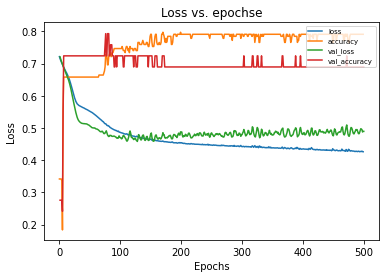

In [107]:
def plot_history(hist, validation_freq=1,scale=1):    
    plt.figure()
    for key, loss in hist.history.items():
        np_loss=np.array(loss)
        if "val" in key:
            plt.plot(np.arange(np_loss.shape[0])*validation_freq+validation_freq,np_loss, label=key)
        else:
            plt.plot(np.arange(np_loss.shape[0]), np_loss, label=key)
        
    plt.xlabel('Epochs')
    plt.ylabel('Loss ')
    plt.title('Loss vs. epochse')
    plt.legend(loc='upper right', fontsize='x-small')
    plt.show()

plot_history(hist) 

In [104]:
assert hist.history['accuracy'][-1]> 0.7
assert hist.history['val_accuracy'][-1]> 0.5